In [1]:
import os
# Enforces CPU-only execution of torch
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Configure environment to ensure single-threaded execution.
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"]= "1"
os.environ["OMP_NUM_THREADS"] = "1"

import torch
torch.set_num_threads(1)

from xtr.datasets import BEIR, BEIRDataset, LoTTE, LoTTEDataset
from xtr.config import XTRConfig, XTRModel, XTRScaNNIndexConfig, XTRBruteForceIndexConfig, XTRFAISSIndexConfig
from xtr.utils import xtr_tracker, canonical_index_name
from xtr.modeling.xtr import XTR

import json
from datetime import datetime

/future/u/scheerer/miniconda3/envs/xtr-eval/lib/python3.8/site-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
NUM_QUERIES = 5
DOCUMENT_TOP_K = 100
TOKEN_TOP_K = 10_000

In [3]:
dataset = LoTTEDataset(dataset=LoTTE.LIFESTYLE, datasplit="test")
index_config = XTRScaNNIndexConfig()
index_name = canonical_index_name(dataset=dataset, index_config=index_config)
config = XTRConfig(index_name=index_name, model=XTRModel.BASE_EN, index_config=index_config, override=False)

xtr = XTR(config=config, collection=dataset.collection, device=torch.device("cpu"))

#> Loading collection from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/test/collection.tsv ...
0M 
#> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/test/questions.search.tsv ...
#> Got 661 queries. All QIDs are unique.
Loading existing index from /future/u/scheerer/home/data/xtr-eval/indexes/LoTTE.LIFESTYLE.search.split=test.XTRIndexType.SCANN.


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 38:5: text format contains deprecated field "min_cluster_size"


In [4]:
from xtr.data.queries import Queries
queries_test = Queries.cast(list(map(lambda x: x[1], dataset.queries))[:NUM_QUERIES])

In [5]:
from xtr.utils.tracker import ExecutionTracker

groups = {
    "Candidate Generation": ["search_batched", "enumerate_scores"],
    "Aggregate Scores": ["get_did2scores", "add_ems", "get_final_score", "sort_scores"]
}

tracker = ExecutionTracker(name=index_name, steps=["Query Encoding", "search_batched", "enumerate_scores", "Estimate Missing Similarity",
                                                   "get_did2scores", "add_ems", "get_final_score", "sort_scores"])
rankings = xtr.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K, tracker=tracker)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


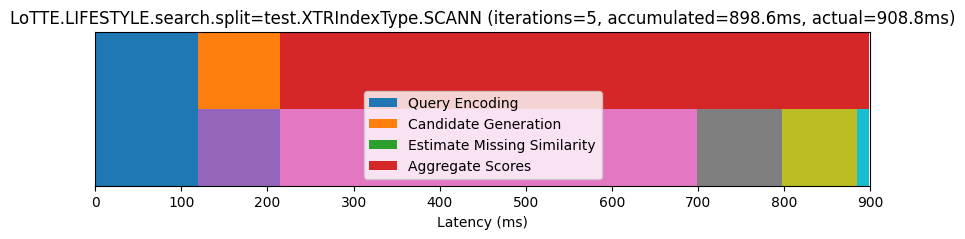

In [10]:
tracker.display_grouped(groups, detailed=True)

In [44]:
from tqdm import tqdm
# Additional Precomputation
ntokens = len(xtr.tid2did) - 1 # tid2did contains -1 for invalid
tid2did_vectorized = torch.zeros(ntokens, dtype=torch.int32)

for key, value in tqdm(xtr.tid2did.items()):
    if key == -1:
        continue
    tid2did_vectorized[key] = value

100%|████████████████████████████████████████████████████████████████████████████████████| 23713178/23713178 [01:32<00:00, 256085.15it/s]


In [45]:
tid2did_vectorized[100_000]

tensor(814, dtype=torch.int32)

In [46]:
xtr.tid2did[100_000]

814

In [103]:
import torch
import numpy as np

from torch_scatter import scatter_max

def _aggregate_scores(self, batch_result, batch_ems, document_top_k, tracker):
    """Aggregates token-level retrieval scores into query-document scores."""
    assert len(batch_result) == 1 and len(batch_ems) == 1

    # TODO(jlscheerer) this is an extremely weird way of storing this!
    # neighbors: (ntokens, token_top_k), represents the token_ids of the retrieved "candidates"
    query_tokens, neighbors, scores = batch_result[0]

    assert neighbors.shape == scores.shape
    ntokens, token_top_k = neighbors.shape
    
    # Total number of unique documents.
    candidate_dids = tid2did_vectorized[neighbors]
    idx_to_candidate_did = torch.unique(candidate_dids.flatten(), sorted=True)
    ncandidates = idx_to_candidate_did.shape[0]

    # Construct a tensor indicating the qtoken_idx for each candidate.
    candidate_qids = torch.repeat_interleave(torch.arange(ntokens), token_top_k)

    # Construct a tensor indicating the index corresponding to each of the candidate document ids.
    candidate_dids_idx = torch.searchsorted(idx_to_candidate_did, candidate_dids.flatten())

    # *Exact* index into the flattened score matrix for (candidate_did, token_idx)
    indices = candidate_dids_idx * self.config.query_maxlen + candidate_qids

    # The score_matrix corresponds to did2scores dictionary.
    score_matrix = torch.zeros((ncandidates, self.config.query_maxlen), dtype=torch.float)

    # Populate the score matrix using the maximum value for each index.
    flat_score_matrix, _ = scatter_max(torch.from_numpy(scores.flatten()), indices, out=score_matrix.view(-1))
    score_matrix = flat_score_matrix.view(score_matrix.size())

    # TODO(jlscheerer) Adapt this once we compute batch_ems more efficiently.
    # i.e., we should directly emit this instead of changing the format here.
    # print(batch_ems)
    ems_vector = torch.zeros(self.config.query_maxlen, dtype=torch.float32)
    for (idx, _), score in batch_ems[0].items():
        ems_vector[idx] = score.item()

    # Apply the ems values column-wise (by replacing zeros).
    ems_matrix = ems_vector.view(1, -1).expand_as(score_matrix)
    zero_mask = score_matrix == 0
    score_matrix[zero_mask] = ems_matrix[zero_mask]

    # Compute the per passage score by summing across rows.
    # NOTE to be consistent with the original implementation we "average" across the number of tokens
    scores = score_matrix.sum(dim=1) / ntokens
    print(scores.shape)

    # TODO(jlscheerer) We could switch to top-k for small document_top_k values.
    scores, indices = torch.sort(scores, stable=True, descending=True)
    document_ids = idx_to_candidate_did[indices]
    
    tracker.begin("get_did2scores")
    def get_did2scores(query_tokens, all_neighbors, all_scores):
        did2scores = {}
        # |Q| x k'
        for qtoken_idx, (qtoken, neighbors, scores) in enumerate(zip(query_tokens, all_neighbors, all_scores)):
            for _, (doc_token_id, score) in enumerate(zip(neighbors, scores)):
                if np.isnan(score):
                    continue
                docid = self.tid2did[doc_token_id]
                if docid not in did2scores:
                    did2scores[docid] = {}
                qtoken_with_idx = (qtoken_idx, qtoken)
                if qtoken_with_idx not in did2scores[docid]:
                    # Only keep the top score for sum-of-max.
                    did2scores[docid][qtoken_with_idx] = score
        return did2scores

    batch_did2scores = [get_did2scores(qtokens, neighbors, scores) for qtokens, neighbors, scores in batch_result]
    tracker.end("get_did2scores")

    tracker.begin("add_ems")
    def add_ems(did2scores, query_tokens, ems):
        # |Q| x |Q|k' (assuming most docid is unique)
        for qtoken_idx, qtoken in enumerate(query_tokens):
            qtoken_with_idx = (qtoken_idx, qtoken)
            for _, scores in did2scores.items():
                if qtoken_with_idx not in scores:
                    scores[qtoken_with_idx] = ems[qtoken_with_idx]

    for did2scores, result, ems in zip(batch_did2scores, batch_result, batch_ems):
        add_ems(did2scores, result[0], ems)
    tracker.end("add_ems")

    # print(batch_did2scores[0][3411])
    # idx = (idx_to_candidate_did == 3411).nonzero(as_tuple=True)[0][0]
    # print(score_matrix[idx])
    
    tracker.begin("get_final_score")
    def get_final_score(did2scores, query_tokens):
        final_qd_score = {}
        # |Q|k' x |Q|
        for docid, scores in did2scores.items():
            assert len(scores) == len(query_tokens)
            final_qd_score[docid] = sum(scores.values()) / len(scores)
        return final_qd_score

    batch_scores = [get_final_score(did2scores, result[0]) for did2scores, result in zip(batch_did2scores, batch_result)]
    tracker.end("get_final_score")

    tracker.begin("sort_scores")
    batch_ranking = [
        sorted([(docid, score) for docid, score in final_qd_score.items()], key=lambda x: x[1], reverse=True)[:document_top_k]
        for final_qd_score in batch_scores
    ]

    print(batch_ranking)

    print("++++++")
    
    # Construct the batch_ranking from the vectorized implementation
    batch_ranking2 = [[(docid.item(), score.item()) for docid, score in zip(document_ids[:document_top_k], scores[:document_top_k])]]
    tracker.end("sort_scores")
    
    return batch_ranking

xtr._aggregate_scores = lambda *args, **kwargs: _aggregate_scores(xtr, *args, **kwargs)

tracker = ExecutionTracker(name=index_name, steps=["Query Encoding", "search_batched", "enumerate_scores", "Estimate Missing Similarity",
                                                   "get_did2scores", "add_ems", "get_final_score", "sort_scores"])
rankings = xtr.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K, tracker=tracker)

  0%|                                                                                                              | 0/5 [00:00<?, ?it/s]

torch.Size([27113])


 20%|████████████████████▍                                                                                 | 1/5 [00:00<00:03,  1.10it/s]

[[(9558, 0.8176491154091698), (16020, 0.7926260126488549), (9538, 0.7726756802627018), (28874, 0.767601415514946), (38827, 0.7658145363841738), (24746, 0.7617714830807277), (32117, 0.7606755707945142), (14700, 0.7580609577042716), (32334, 0.7551365771463939), (8140, 0.753195732831955), (18712, 0.7522060722112656), (4695, 0.7506705437387738), (30308, 0.7502088568040303), (47902, 0.748841541154044), (29978, 0.7472673015935081), (25382, 0.7417777798005513), (5097, 0.7407402715512684), (4375, 0.7388794656310763), (11680, 0.7384013895477567), (36778, 0.7382106504270008), (1713, 0.7375441385166985), (47771, 0.7373921339000974), (20796, 0.7370933166572026), (10106, 0.7370354809931347), (4542, 0.7369830331632069), (6690, 0.7364318328244346), (36322, 0.7363491909844535), (24808, 0.7344173725162234), (2958, 0.7325907456023353), (38894, 0.7312293968030384), (33094, 0.7306002059153148), (44541, 0.7304244829075677), (26862, 0.7301804998091289), (6050, 0.729934532727514), (25172, 0.7297204669032779)

 40%|████████████████████████████████████████▊                                                             | 2/5 [00:01<00:03,  1.01s/it]

[[(8028, 0.8904446959495544), (30833, 0.845202410922331), (14792, 0.8399385108667261), (19460, 0.837474013076109), (45931, 0.8287308496587417), (39047, 0.8282071807805229), (29708, 0.8260064054937923), (41446, 0.8206808917662677), (8037, 0.8169338983647964), (21374, 0.811493505449856), (26690, 0.8074419182889602), (29443, 0.8049977737314561), (46224, 0.8041576918433694), (13143, 0.8018488603479722), (46558, 0.8015402906081256), (37652, 0.8014283636037041), (5246, 0.8007748091922087), (9083, 0.7992120770847096), (18540, 0.7983060233733233), (20789, 0.7981393337249756), (6929, 0.7967120899873621), (9938, 0.7954591898357167), (871, 0.7950373467277078), (3205, 0.7947226657586939), (9535, 0.7943396533236784), (9032, 0.7942206824527067), (30551, 0.7931286762742435), (5245, 0.7931227964513442), (18465, 0.7929268444285673), (8049, 0.7925483654527103), (20215, 0.7912116541581995), (19439, 0.7909785544171053), (3400, 0.7907144076683942), (9527, 0.790670352823594), (31777, 0.7902419286615708), (3

 60%|█████████████████████████████████████████████████████████████▏                                        | 3/5 [00:02<00:01,  1.11it/s]

[[(13342, 0.8632800395672138), (18090, 0.8509434507443354), (5365, 0.8471846122008103), (41795, 0.8436337342629066), (47470, 0.8366244710408725), (41170, 0.8355391254791846), (11944, 0.8169779594127948), (17320, 0.8161362272042495), (15766, 0.8046179551344651), (43648, 0.8045139496143048), (11570, 0.8043678448750422), (19660, 0.8006489460284894), (47379, 0.7996588395192072), (26411, 0.7984867233496445), (26409, 0.7934298836267911), (16400, 0.7934048634309036), (21308, 0.7922783218897306), (2351, 0.7907611498465905), (44364, 0.7903313866028419), (39588, 0.7888118395438561), (30108, 0.7859044762758108), (37957, 0.7831311500989474), (46261, 0.7822484007248511), (1915, 0.7815664181342492), (1913, 0.7815492886763352), (12603, 0.7809730447255648), (31499, 0.7803153716600858), (6011, 0.7795325655203599), (32490, 0.7794490548280569), (13811, 0.7793305057745713), (28573, 0.7792233366232652), (27814, 0.7789381054731516), (15356, 0.7785044954373286), (40938, 0.7778336405754089), (30113, 0.7766878

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 4/5 [00:04<00:01,  1.11s/it]

[[(2294, 0.8660654317248951), (26421, 0.8359849452972412), (41673, 0.8155040713873777), (23121, 0.8110963512550701), (37157, 0.8099480433897539), (39017, 0.8047136068344116), (23116, 0.799103625796058), (30050, 0.7982345575636084), (41117, 0.780140524560755), (26609, 0.7737672166390852), (46276, 0.7735063433647156), (30605, 0.773336494510824), (3146, 0.7714731584895741), (5037, 0.7706194763833826), (39284, 0.768111375245181), (17169, 0.7671457610347054), (48106, 0.7663343223658475), (5334, 0.7641398337754336), (3171, 0.7632582566954873), (44404, 0.7626014351844788), (3005, 0.7624528949910944), (32982, 0.7611533809791912), (44047, 0.758884462443265), (23122, 0.7577219280329618), (47651, 0.7577082460576837), (39633, 0.7569046724926342), (30049, 0.7561587528748945), (30574, 0.755691487680782), (46148, 0.7555936602028933), (3170, 0.7555585909973491), (30577, 0.7553909908641468), (42121, 0.75440868193453), (24192, 0.7540237443013624), (46324, 0.7535956447774713), (9110, 0.753036615523425), 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]

[[(29835, 0.9007669849829241), (4177, 0.8505422472953796), (32917, 0.8428038304502313), (10228, 0.8402713591402228), (10777, 0.836438617923043), (32912, 0.8255515152757819), (20324, 0.8217414129864086), (13078, 0.8190570636229082), (14887, 0.8181582526727156), (16690, 0.81700537963347), (27667, 0.8164071928371083), (47632, 0.8158409541303461), (19396, 0.8147809613834728), (35570, 0.8136210549961437), (16694, 0.8122495792128823), (20552, 0.812157229943709), (8278, 0.811995186588981), (37601, 0.8118877410888672), (37397, 0.8105927814136852), (27852, 0.810408586805517), (16074, 0.8099603978070345), (41491, 0.8098755803975192), (27379, 0.8087968338619579), (15535, 0.8076375668699091), (37763, 0.8071388114582408), (11467, 0.8064429759979248), (46286, 0.8062074238603766), (43624, 0.8043815060095354), (38099, 0.8038586486469615), (28406, 0.8038103526288812), (46732, 0.8026901266791604), (43599, 0.8023603016679938), (5450, 0.8013054836880077), (25591, 0.8009368506344882), (8606, 0.800864875316

In [9]:
dataset.eval(rankings)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



{'Success@5': 0.7564296520423601}